In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_excel("/home/margaux/code/projet-final/data/online_retail_II.xlsx")

df.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom


In [12]:
print(df.columns)

Index(['Invoice', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'Price', 'Customer ID', 'Country'],
      dtype='object')


In [13]:
df = df.dropna(subset=["Customer ID"])

df = df[~df["Invoice"].astype(str).str.startswith("C")]

df["TotalPrice"] = df["Quantity"] * df["Price"]

df["InvoiceDate"] = pd.to_datetime(df["InvoiceDate"])


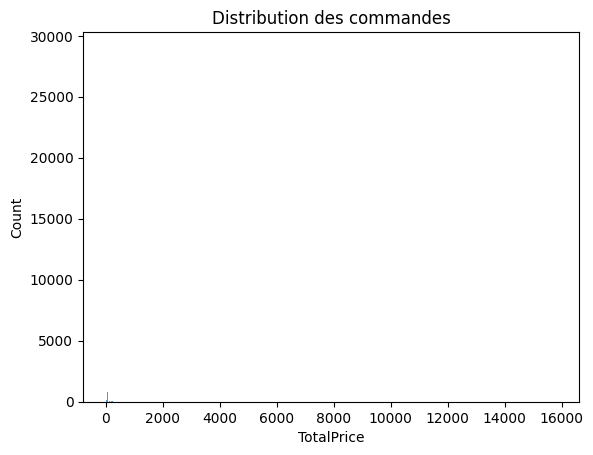

In [15]:
plt.figure()
sns.histplot(df["TotalPrice"])
plt.title("Distribution des commandes")
plt.show()

/tmp/ipykernel_1758/3461398915.py:1: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  ts = df.set_index("InvoiceDate").resample("M")["TotalPrice"].sum()


<Axes: title={'center': 'Revenu mensuel'}, xlabel='InvoiceDate'>

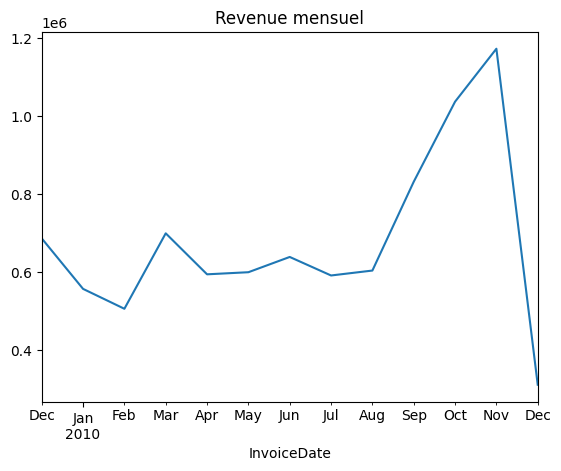

In [16]:
ts = df.set_index("InvoiceDate").resample("M")["TotalPrice"].sum()
ts.plot(title="Revenu mensuel")

In [18]:
df['InvoiceMonth'] = df['InvoiceDate'].dt.to_period('M')
df['CohortMonth'] = df.groupby('Customer ID')['InvoiceMonth'].transform('min')
cohorts = df.groupby(['CohortMonth','InvoiceMonth'])['Customer ID'].nunique().unstack()
cohorts

InvoiceMonth,2009-12,2010-01,2010-02,2010-03,2010-04,2010-05,2010-06,2010-07,2010-08,2010-09,2010-10,2010-11,2010-12
CohortMonth,,,,,,,,,,,,,
2009-12,955.0,337.0,319.0,406.0,363.0,343.0,360.0,327.0,321.0,346.0,403.0,473.0,237.0
2010-01,NaN,383.0,79.0,119.0,117.0,101.0,115.0,99.0,88.0,107.0,122.0,116.0,38.0
2010-02,NaN,NaN,376.0,89.0,84.0,109.0,92.0,75.0,72.0,107.0,95.0,103.0,27.0
2010-03,NaN,NaN,NaN,443.0,84.0,102.0,107.0,103.0,90.0,109.0,134.0,122.0,35.0
2010-04,NaN,NaN,NaN,NaN,294.0,57.0,57.0,48.0,54.0,66.0,81.0,77.0,20.0
2010-05,NaN,NaN,NaN,NaN,NaN,254.0,40.0,43.0,44.0,45.0,65.0,54.0,20.0
2010-06,NaN,NaN,NaN,NaN,NaN,NaN,270.0,47.0,51.0,55.0,62.0,77.0,18.0
2010-07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,186.0,29.0,34.0,55.0,54.0,19.0
2010-08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,162.0,33.0,48.0,52.0,19.0


In [19]:
print("Doublons :", df.duplicated().sum())
df = df.drop_duplicates()

Doublons : 6748


In [20]:
print("Quantités négatives :", (df['Quantity'] < 0).sum())
print("Prix négatifs :", (df['Price'] < 0).sum())

df = df[(df['Quantity'] > 0) & (df['Price'] > 0)]


Quantités négatives : 0
Prix négatifs : 0


In [21]:
snapshot_date = df['InvoiceDate'].max() + pd.Timedelta(days=1)
rfm = df.groupby('Customer ID').agg({
    'InvoiceDate': lambda x: (snapshot_date - x.max()).days,
    'Invoice': 'nunique',
    'TotalPrice': 'sum'
})
rfm.rename(columns={'InvoiceDate': 'Recency', 'Invoice': 'Frequency', 'TotalPrice': 'Monetary'}, inplace=True)
rfm.head()


,Recency,Frequency,Monetary
Customer ID,,,
12346.0,165,11,372.86
12347.0,3,2,1323.32
12348.0,74,1,222.16
12349.0,43,3,2671.14
12351.0,11,1,300.93


In [22]:
quantiles = rfm.quantile(q=[0.25,0.5,0.75]).to_dict()

def r_score(x,p,d):
    if x <= d[p][0.25]:
        return 4
    elif x <= d[p][0.50]:
        return 3
    elif x <= d[p][0.75]:
        return 2
    else:
        return 1

def fm_score(x,p,d):
    if x <= d[p][0.25]:
        return 1
    elif x <= d[p][0.50]:
        return 2
    elif x <= d[p][0.75]:
        return 3
    else:
        return 4

rfm['R'] = rfm['Recency'].apply(r_score, args=('Recency',quantiles))
rfm['F'] = rfm['Frequency'].apply(fm_score, args=('Frequency',quantiles))
rfm['M'] = rfm['Monetary'].apply(fm_score, args=('Monetary',quantiles))
rfm['RFM_Score'] = rfm['R'].map(str) + rfm['F'].map(str) + rfm['M'].map(str)
rfm.head()


,Recency,Frequency,Monetary,R,F,M,RFM_Score
Customer ID,,,,,,,
12346.0,165,11,372.86,1,4,2,142
12347.0,3,2,1323.32,4,2,3,423
12348.0,74,1,222.16,2,1,1,211
12349.0,43,3,2671.14,3,3,4,334
12351.0,11,1,300.93,4,1,1,411


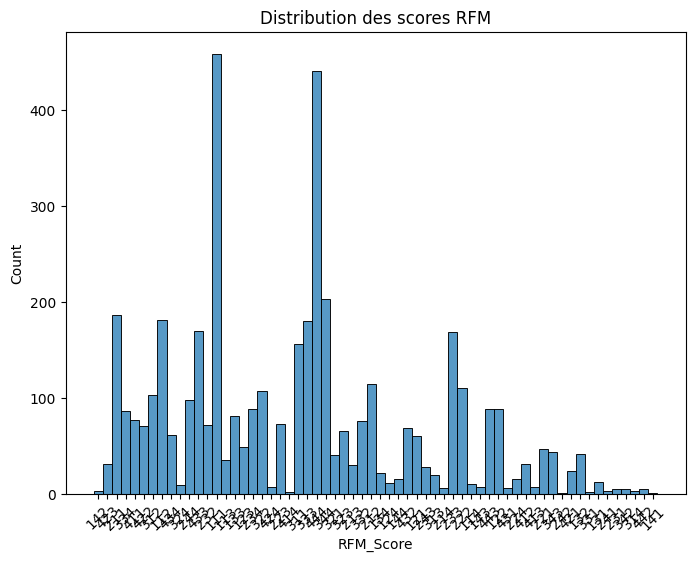

In [23]:
plt.figure(figsize=(8,6))
sns.histplot(rfm['RFM_Score'], bins=20)
plt.title("Distribution des scores RFM")
plt.xticks(rotation=45)
plt.show()


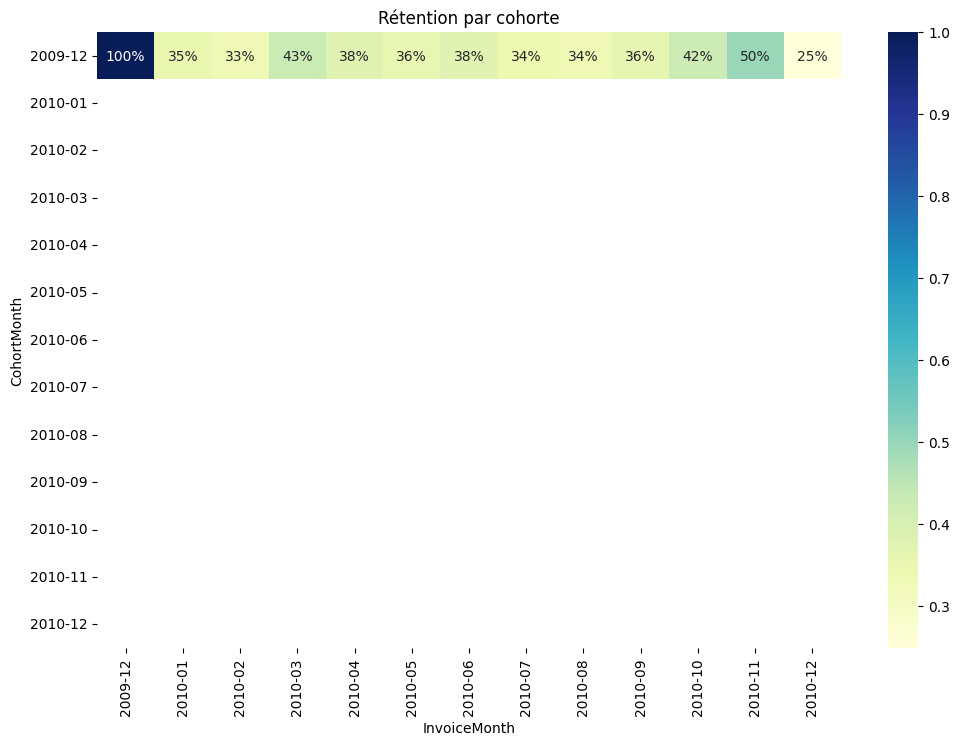

In [24]:
cohort_sizes = cohorts
retention = cohort_sizes.divide(cohort_sizes.iloc[:,0], axis=0)
plt.figure(figsize=(12,8))
sns.heatmap(retention, annot=True, fmt=".0%", cmap="YlGnBu")
plt.title("Rétention par cohorte")
plt.show()

In [25]:
# Clients par pays
df['Country'].value_counts().head(10)

# CA par pays
df.groupby('Country')['TotalPrice'].sum().sort_values(ascending=False).head(10)

# CA total, moyenne par commande, etc.
print("CA total :", df['TotalPrice'].sum())
print("Panier moyen :", df['TotalPrice'].mean())


CA total : 8798233.743999999
Panier moyen : 21.94532955531832


In [26]:
# Créer le dossier processed si ce n'est pas déjà fait
import os
os.makedirs("/home/margaux/code/projet-final/data/processed", exist_ok=True)

# Enregistrer le DataFrame nettoyé
processed_path = "/home/margaux/code/projet-final/data/processed/online_retail_II_cleaned.csv"
df.to_csv(processed_path, index=False, encoding='utf-8')
print(f"Données nettoyées sauvegardées dans : {processed_path}")


Données nettoyées sauvegardées dans : /home/margaux/code/projet-final/data/processed/online_retail_II_cleaned.csv


In [4]:
"""
Script pour préparer les données Online Retail
"""

import pandas as pd
import numpy as np
from pathlib import Path

def prepare_data(input_path, output_path):
    """Charge et nettoie les données"""
    print("Chargement des données...")
    
    # Charger
    if input_path.endswith('.xlsx'):
        df = pd.read_excel(input_path)
    else:
        df = pd.read_csv(input_path, encoding='utf-8')
    
    print(f"Lignes chargées: {len(df):,}")
    print(f"Colonnes: {list(df.columns)}")
    
    print("\nNettoyage...")
    
    # Stats avant nettoyage
    print(f"Lignes initiales: {len(df):,}")
    print(f"Customer ID manquants: {df['Customer ID'].isna().sum():,}")
    
    # Nettoyer les colonnes
    df.columns = df.columns.str.strip()
    
    # Supprimer les lignes sans Customer ID
    df = df.dropna(subset=['Customer ID'])
    print(f"Après suppression NaN: {len(df):,} lignes")
    
    # Convertir Customer ID en entier
    df['Customer ID'] = df['Customer ID'].astype(int)
    
    # Convertir la date
    df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
    
    # Identifier les retours
    df['IsReturn'] = df['Invoice'].astype(str).str.startswith('C')
    print(f"Retours identifiés: {df['IsReturn'].sum():,} lignes")
    
    # Calculer le montant
    df['Amount'] = df['Quantity'] * df['Price']
    
    # Stats
    print("\nStatistiques:")
    print(f"Montant min: £{df['Amount'].min():.2f}")
    print(f"Montant max: £{df['Amount'].max():.2f}")
    print(f"Montant moyen: £{df['Amount'].mean():.2f}")
    
    # Trier par date
    df = df.sort_values('InvoiceDate')
    
    # Infos finales
    print("\nDonnées nettoyées:")
    print(f"Lignes finales: {len(df):,}")
    print(f"Clients uniques: {df['Customer ID'].nunique():,}")
    print(f"Période: {df['InvoiceDate'].min().date()} à {df['InvoiceDate'].max().date()}")
    print(f"Pays: {df['Country'].nunique()}")
    print(f"CA total: £{df[~df['IsReturn']]['Amount'].sum():,.2f}")
    
    # Sauvegarder
    print(f"\nSauvegarde vers {output_path}...")
    output_path = Path(output_path)
    output_path.parent.mkdir(parents=True, exist_ok=True)
    
    df.to_csv(output_path, index=False)
    print(f"Fichier sauvegardé")
    
    return df

if __name__ == "__main__":
    INPUT_FILE = "/home/margaux/code/projet-final/data/online_retail_II.xlsx"
    OUTPUT_FILE = "data/processed/online_retail_clean.csv"
    
    print("PRÉPARATION DES DONNÉES")
    print("="*60)
    
    try:
        df = prepare_data(INPUT_FILE, OUTPUT_FILE)
        
        print("\nPréparation terminée!")
        print(f"Fichier prêt: {OUTPUT_FILE}")
        print("\nVous pouvez lancer l'app:")
        print("streamlit run app/app.py")
        
    except FileNotFoundError:
        print(f"\nErreur: Fichier '{INPUT_FILE}' non trouvé")
        print("Mettez le fichier dans data/raw/")
    except Exception as e:
        print(f"\nErreur: {str(e)}")

PRÉPARATION DES DONNÉES
Chargement des données...
Lignes chargées: 525,461
Colonnes: ['Invoice', 'StockCode', 'Description', 'Quantity', 'InvoiceDate', 'Price', 'Customer ID', 'Country']

Nettoyage...
Lignes initiales: 525,461
Customer ID manquants: 107,927
Après suppression NaN: 417,534 lignes
Retours identifiés: 9,839 lignes

Statistiques:
Montant min: £-25111.09
Montant max: £15818.40
Montant moyen: £19.99

Données nettoyées:
Lignes finales: 417,534
Clients uniques: 4,383
Période: 2009-12-01 à 2010-12-09
Pays: 37
CA total: £8,832,003.27

Sauvegarde vers data/processed/online_retail_clean.csv...
Fichier sauvegardé

Préparation terminée!
Fichier prêt: data/processed/online_retail_clean.csv

Vous pouvez lancer l'app:
streamlit run app/app.py


FICHE SYNTHETIQUE DES DONNEES - ONLINE RETAIL II

📊 SOURCE
- Dataset: Online Retail II (UCI Machine Learning Repository)
- Description: Transactions e-commerce d'un détaillant UK
- Licence: CC BY 4.0

📅 PERIODE COUVERTE
- Début: 2009-12-01 07:45:00
- Fin: 2010-12-09 20:01:00
- Durée: 373 jours

📈 VOLUME
- Nombre de lignes: 525,461
- Nombre de transactions: 28,816
- Nombre de clients: 417,534
- Nombre de produits: 4,632
- Nombre de pays: 40

📋 COLONNES IMPORTANTES
['Invoice', 'StockCode', 'Description', 'Quantity', 'InvoiceDate', 'Price', 'Customer ID', 'Country']

DICTIONNAIRE DES VARIABLES

Invoice:
  - type: object (string)
  - description: Numéro de facture unique. Les factures commençant par "C" sont des annulations/retours
  - exemple: 536365, C536379

StockCode:
  - type: object (string)
  - description: Code produit unique
  - exemple: 85123A, POST

Description:
  - type: object (string)
  - description: Nom du produit
  - exemple: WHITE HANGING HEART T-LIGHT HOLDER

Quantity:
 

FileNotFoundError: [Errno 2] No such file or directory: 'docs/graph1_distribution_montants.png'

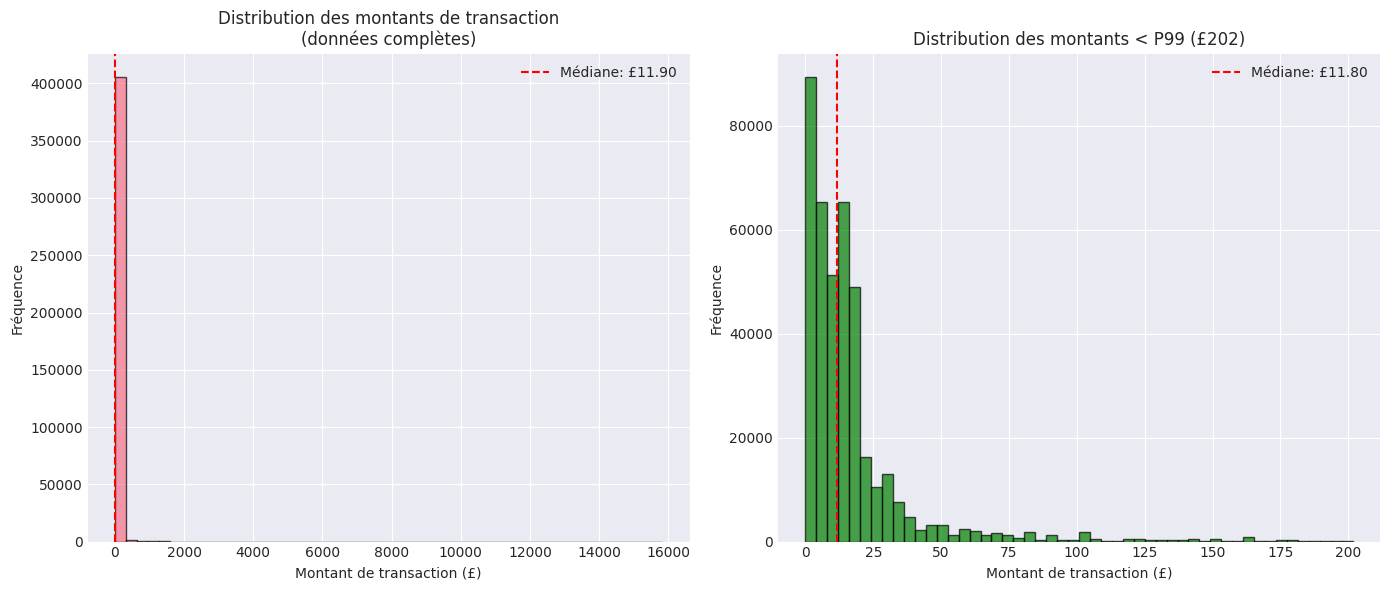

In [ ]:
"""
NOTEBOOK D'EXPLORATION VISUELLE - ONLINE RETAIL II
Projet Marketing Analytics - Cohortes, RFM, CLV
"""

# ============================================================================
# IMPORTS
# ============================================================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Configuration des graphiques
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10

# ============================================================================
# 1. FICHE SYNTHETIQUE DES DONNEES
# ============================================================================
print("="*80)
print("FICHE SYNTHETIQUE DES DONNEES - ONLINE RETAIL II")
print("="*80)

# Charger les données
df = pd.read_excel('/home/margaux/code/projet-final/data/online_retail_II.xlsx')

print("\n📊 SOURCE")
print("- Dataset: Online Retail II (UCI Machine Learning Repository)")
print("- Description: Transactions e-commerce d'un détaillant UK")
print("- Licence: CC BY 4.0")

print("\n📅 PERIODE COUVERTE")
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
print(f"- Début: {df['InvoiceDate'].min()}")
print(f"- Fin: {df['InvoiceDate'].max()}")
print(f"- Durée: {(df['InvoiceDate'].max() - df['InvoiceDate'].min()).days} jours")

print("\n📈 VOLUME")
print(f"- Nombre de lignes: {len(df):,}")
print(f"- Nombre de transactions: {df['Invoice'].nunique():,}")
print(f"- Nombre de clients: {df['Customer ID'].notna().sum():,}")
print(f"- Nombre de produits: {df['StockCode'].nunique():,}")
print(f"- Nombre de pays: {df['Country'].nunique()}")

print("\n📋 COLONNES IMPORTANTES")
print(df.columns.tolist())

# ============================================================================
# 2. DICTIONNAIRE DES VARIABLES
# ============================================================================
print("\n" + "="*80)
print("DICTIONNAIRE DES VARIABLES")
print("="*80)

dict_variables = {
    'Invoice': {
        'type': 'object (string)',
        'description': 'Numéro de facture unique. Les factures commençant par "C" sont des annulations/retours',
        'exemple': '536365, C536379'
    },
    'StockCode': {
        'type': 'object (string)',
        'description': 'Code produit unique',
        'exemple': '85123A, POST'
    },
    'Description': {
        'type': 'object (string)',
        'description': 'Nom du produit',
        'exemple': 'WHITE HANGING HEART T-LIGHT HOLDER'
    },
    'Quantity': {
        'type': 'int64',
        'description': 'Quantité de produits par transaction. Négative pour les retours',
        'unite': 'unités'
    },
    'InvoiceDate': {
        'type': 'datetime64',
        'description': 'Date et heure de la transaction',
        'format': 'YYYY-MM-DD HH:MM:SS'
    },
    'Price': {
        'type': 'float64',
        'description': 'Prix unitaire du produit',
        'unite': 'GBP (£)'
    },
    'Customer ID': {
        'type': 'float64',
        'description': 'Identifiant unique du client. Peut être manquant pour les transactions sans compte',
        'exemple': '17850.0, 13047.0'
    },
    'Country': {
        'type': 'object (string)',
        'description': 'Pays du client',
        'exemple': 'United Kingdom, France, Germany'
    }
}

for col, info in dict_variables.items():
    print(f"\n{col}:")
    for key, value in info.items():
        print(f"  - {key}: {value}")

# ============================================================================
# 3. QUALITE DES DONNEES
# ============================================================================
print("\n" + "="*80)
print("QUALITE DES DONNEES")
print("="*80)

# Valeurs manquantes
print("\n📍 VALEURS MANQUANTES")
missing = df.isnull().sum()
missing_pct = (missing / len(df) * 100).round(2)
missing_df = pd.DataFrame({
    'Colonne': df.columns,
    'Manquants': missing.values,
    'Pourcentage': missing_pct.values
})
print(missing_df[missing_df['Manquants'] > 0])

# Doublons
print("\n📍 DOUBLONS")
duplicates = df.duplicated().sum()
print(f"Nombre de lignes dupliquées: {duplicates:,} ({duplicates/len(df)*100:.2f}%)")

# Retours (factures commençant par C)
print("\n📍 RETOURS (Invoices commençant par 'C')")
df['IsReturn'] = df['Invoice'].astype(str).str.startswith('C')
nb_returns = df['IsReturn'].sum()
print(f"Nombre de lignes de retours: {nb_returns:,} ({nb_returns/len(df)*100:.2f}%)")

# Outliers
print("\n📍 OUTLIERS")
df['Amount'] = df['Quantity'] * df['Price']
df_no_returns = df[~df['IsReturn']]

print(f"Prix unitaire:")
print(f"  - Min: £{df_no_returns['Price'].min():.2f}")
print(f"  - Max: £{df_no_returns['Price'].max():.2f}")
print(f"  - Médiane: £{df_no_returns['Price'].median():.2f}")
print(f"  - Moyenne: £{df_no_returns['Price'].mean():.2f}")

print(f"\nMontant de transaction:")
print(f"  - Min: £{df_no_returns['Amount'].min():.2f}")
print(f"  - Max: £{df_no_returns['Amount'].max():.2f}")
print(f"  - Médiane: £{df_no_returns['Amount'].median():.2f}")
print(f"  - Moyenne: £{df_no_returns['Amount'].mean():.2f}")
print(f"  - P99: £{df_no_returns['Amount'].quantile(0.99):.2f}")

# Granularité temporelle
print("\n📍 GRANULARITE TEMPORELLE")
df['Date'] = df['InvoiceDate'].dt.date
daily_transactions = df.groupby('Date').size()
print(f"Transactions par jour:")
print(f"  - Min: {daily_transactions.min():,}")
print(f"  - Max: {daily_transactions.max():,}")
print(f"  - Moyenne: {daily_transactions.mean():.0f}")

# ============================================================================
# GRAPHIQUES VISUELS
# ============================================================================

# Nettoyer les données pour les graphiques
df_clean = df.dropna(subset=['Customer ID'])
df_clean['Customer ID'] = df_clean['Customer ID'].astype(int)
df_clean = df_clean[~df_clean['IsReturn']]

print("\n" + "="*80)
print("GENERATION DES GRAPHIQUES")
print("="*80)

# ============================================================================
# GRAPHIQUE 1: Distribution des montants de transaction
# ============================================================================
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
# Distribution complète
amounts = df_clean['Amount']
plt.hist(amounts[amounts > 0], bins=50, edgecolor='black', alpha=0.7)
plt.xlabel('Montant de transaction (£)')
plt.ylabel('Fréquence')
plt.title('Distribution des montants de transaction\n(données complètes)')
plt.axvline(amounts.median(), color='red', linestyle='--', label=f'Médiane: £{amounts.median():.2f}')
plt.legend()

plt.subplot(1, 2, 2)
# Distribution sans outliers (< P99)
p99 = amounts.quantile(0.99)
amounts_filtered = amounts[amounts <= p99]
plt.hist(amounts_filtered, bins=50, edgecolor='black', alpha=0.7, color='green')
plt.xlabel('Montant de transaction (£)')
plt.ylabel('Fréquence')
plt.title(f'Distribution des montants < P99 (£{p99:.0f})')
plt.axvline(amounts_filtered.median(), color='red', linestyle='--', label=f'Médiane: £{amounts_filtered.median():.2f}')
plt.legend()

plt.tight_layout()
plt.savefig('/home/margaux/code/projet-final/docs/graph1_distribution_montants.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Graphique 1 sauvegardé: Distribution des montants")
print("INTERPRETATION: La majorité des transactions sont de faible montant (< £50).")
print("Les outliers (> P99) représentent des commandes exceptionnelles ou en gros.")

# ============================================================================
# GRAPHIQUE 2: Evolution mensuelle du CA et nombre de transactions
# ============================================================================
fig, ax1 = plt.subplots(figsize=(14, 6))

# Préparer les données mensuelles
df_clean['YearMonth'] = df_clean['InvoiceDate'].dt.to_period('M')
monthly_stats = df_clean.groupby('YearMonth').agg({
    'Amount': 'sum',
    'Invoice': 'nunique'
}).reset_index()
monthly_stats['YearMonth'] = monthly_stats['YearMonth'].astype(str)

# CA
color = 'tab:blue'
ax1.set_xlabel('Mois')
ax1.set_ylabel('Chiffre d\'Affaires (£)', color=color)
ax1.plot(monthly_stats['YearMonth'], monthly_stats['Amount'], color=color, marker='o', linewidth=2)
ax1.tick_params(axis='y', labelcolor=color)
ax1.tick_params(axis='x', rotation=45)

# Nombre de transactions
ax2 = ax1.twinx()
color = 'tab:orange'
ax2.set_ylabel('Nombre de transactions', color=color)
ax2.plot(monthly_stats['YearMonth'], monthly_stats['Invoice'], color=color, marker='s', linewidth=2)
ax2.tick_params(axis='y', labelcolor=color)

plt.title('Evolution mensuelle du CA et du nombre de transactions', fontsize=14, fontweight='bold')
fig.tight_layout()
plt.savefig('/home/margaux/code/projet-final/docs/graph2_evolution_mensuelle.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Graphique 2 sauvegardé: Evolution mensuelle")
print("INTERPRETATION: Saisonnalité visible avec pics en novembre (Black Friday / Noël).")
print("Croissance globale du CA et du volume de transactions sur la période.")

# ============================================================================
# GRAPHIQUE 3: Top 10 pays par CA
# ============================================================================
plt.figure(figsize=(12, 6))

top_countries = df_clean.groupby('Country')['Amount'].sum().sort_values(ascending=False).head(10)
colors = sns.color_palette("viridis", len(top_countries))

plt.barh(range(len(top_countries)), top_countries.values, color=colors)
plt.yticks(range(len(top_countries)), top_countries.index)
plt.xlabel('Chiffre d\'Affaires (£)')
plt.title('Top 10 des pays par CA', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()

# Ajouter les valeurs
for i, v in enumerate(top_countries.values):
    plt.text(v, i, f' £{v:,.0f}', va='center')

plt.tight_layout()
plt.savefig('/home/margaux/code/projet-final/docs/graph3_top_pays.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Graphique 3 sauvegardé: Top pays")
print(f"INTERPRETATION: Le UK domine avec {top_countries.iloc[0]/top_countries.sum()*100:.1f}% du CA total.")
print("Le marché est très concentré sur quelques pays européens.")

# ============================================================================
# GRAPHIQUE 4: Distribution des quantités (volume vs valeur)
# ============================================================================
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Transactions par volume
quantity_dist = df_clean.groupby('Invoice')['Quantity'].sum()
axes[0].hist(quantity_dist[quantity_dist <= 100], bins=30, edgecolor='black', alpha=0.7, color='steelblue')
axes[0].set_xlabel('Quantité totale par commande')
axes[0].set_ylabel('Nombre de commandes')
axes[0].set_title('Distribution des quantités par commande\n(< 100 unités)')
axes[0].axvline(quantity_dist.median(), color='red', linestyle='--', label=f'Médiane: {quantity_dist.median():.0f}')
axes[0].legend()

# Distribution du panier moyen
basket = df_clean.groupby('Invoice')['Amount'].sum()
axes[1].hist(basket[basket <= basket.quantile(0.95)], bins=30, edgecolor='black', alpha=0.7, color='coral')
axes[1].set_xlabel('Montant par commande (£)')
axes[1].set_ylabel('Nombre de commandes')
axes[1].set_title('Distribution du panier moyen\n(< P95)')
axes[1].axvline(basket.median(), color='red', linestyle='--', label=f'Médiane: £{basket.median():.0f}')
axes[1].legend()

plt.tight_layout()
plt.savefig('/home/margaux/code/projet-final/docs/graph4_distribution_quantites.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Graphique 4 sauvegardé: Distribution quantités/panier")
print(f"INTERPRETATION: Panier médian de £{basket.median():.0f}.")
print("Distinction entre petites commandes retail et grosses commandes wholesale.")

# ============================================================================
# GRAPHIQUE 5: Premier aperçu des cohortes
# ============================================================================
# Créer les cohortes
df_cohort = df_clean.copy()
df_cohort['CohortMonth'] = df_cohort.groupby('Customer ID')['InvoiceDate'].transform('min').dt.to_period('M')
df_cohort['OrderMonth'] = df_cohort['InvoiceDate'].dt.to_period('M')
df_cohort['CohortAge'] = (df_cohort['OrderMonth'] - df_cohort['CohortMonth']).apply(lambda x: x.n)

# Compter les clients par cohorte
cohort_size = df_cohort[df_cohort['CohortAge'] == 0].groupby('CohortMonth')['Customer ID'].nunique()

plt.figure(figsize=(14, 6))
cohort_size_df = cohort_size.reset_index()
cohort_size_df['CohortMonth'] = cohort_size_df['CohortMonth'].astype(str)

plt.bar(cohort_size_df['CohortMonth'], cohort_size_df['Customer ID'], color='teal', alpha=0.7, edgecolor='black')
plt.xlabel('Mois d\'acquisition')
plt.ylabel('Nombre de nouveaux clients')
plt.title('Taille des cohortes d\'acquisition par mois', fontsize=14, fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.axhline(cohort_size.mean(), color='red', linestyle='--', label=f'Moyenne: {cohort_size.mean():.0f}')
plt.legend()

plt.tight_layout()
plt.savefig('/home/margaux/code/projet-final/docs/graph5_cohortes_acquisition.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Graphique 5 sauvegardé: Cohortes d'acquisition")
print(f"INTERPRETATION: Moyenne de {cohort_size.mean():.0f} nouveaux clients par mois.")
print("Pics d'acquisition en fin d'année (période de Noël).")

# ============================================================================
# GRAPHIQUE 6: Rétention M+1, M+3, M+6
# ============================================================================
# Calculer la rétention
cohort_data = df_cohort.groupby(['CohortMonth', 'CohortAge'])['Customer ID'].nunique().reset_index()
cohort_data.columns = ['CohortMonth', 'CohortAge', 'Customers']

cohort_sizes = cohort_data[cohort_data['CohortAge'] == 0].set_index('CohortMonth')['Customers']
retention_matrix = cohort_data.pivot_table(index='CohortMonth', columns='CohortAge', values='Customers')
retention_rate = retention_matrix.divide(cohort_sizes, axis=0) * 100

# Extraire M+1, M+3, M+6
retention_summary = pd.DataFrame({
    'M+1': retention_rate[1] if 1 in retention_rate.columns else np.nan,
    'M+3': retention_rate[3] if 3 in retention_rate.columns else np.nan,
    'M+6': retention_rate[6] if 6 in retention_rate.columns else np.nan
}).dropna()

plt.figure(figsize=(14, 6))
x = np.arange(len(retention_summary))
width = 0.25

plt.bar(x - width, retention_summary['M+1'], width, label='M+1', color='#3498db')
plt.bar(x, retention_summary['M+3'], width, label='M+3', color='#e74c3c')
plt.bar(x + width, retention_summary['M+6'], width, label='M+6', color='#2ecc71')

plt.xlabel('Cohorte')
plt.ylabel('Taux de rétention (%)')
plt.title('Taux de rétention par cohorte (M+1, M+3, M+6)', fontsize=14, fontweight='bold')
plt.xticks(x, retention_summary.index.astype(str), rotation=45, ha='right')
plt.legend()
plt.axhline(retention_summary['M+1'].mean(), color='#3498db', linestyle='--', alpha=0.5)
plt.axhline(retention_summary['M+3'].mean(), color='#e74c3c', linestyle='--', alpha=0.5)
plt.axhline(retention_summary['M+6'].mean(), color='#2ecc71', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.savefig('/home/margaux/code/projet-final/docs/graph6_retention_cohortes.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Graphique 6 sauvegardé: Rétention par cohorte")
print(f"INTERPRETATION: Rétention M+1 moyenne: {retention_summary['M+1'].mean():.1f}%")
print(f"Rétention M+3 moyenne: {retention_summary['M+3'].mean():.1f}%")
print("Forte dégradation de la rétention dans les premiers mois.")

# ============================================================================
# GRAPHIQUE 7: Premier profil RFM (Scatter plot Frequency vs Monetary)
# ============================================================================
analysis_date = df_clean['InvoiceDate'].max()

rfm = df_clean.groupby('Customer ID').agg({
    'InvoiceDate': lambda x: (analysis_date - x.max()).days,
    'Invoice': 'nunique',
    'Amount': 'sum'
}).reset_index()
rfm.columns = ['Customer ID', 'Recency', 'Frequency', 'Monetary']

plt.figure(figsize=(12, 8))
scatter = plt.scatter(rfm['Frequency'], rfm['Monetary'], 
                     c=rfm['Recency'], cmap='RdYlGn_r', 
                     alpha=0.6, s=50, edgecolors='black', linewidth=0.5)
plt.colorbar(scatter, label='Recency (jours)')
plt.xlabel('Frequency (nombre de commandes)')
plt.ylabel('Monetary (CA total en £)')
plt.title('Profil RFM: Frequency vs Monetary (couleur = Recency)', fontsize=14, fontweight='bold')
plt.xlim(0, rfm['Frequency'].quantile(0.95))
plt.ylim(0, rfm['Monetary'].quantile(0.95))

# Ajouter des lignes de référence
plt.axvline(rfm['Frequency'].median(), color='blue', linestyle='--', alpha=0.5, label='Médiane Frequency')
plt.axhline(rfm['Monetary'].median(), color='red', linestyle='--', alpha=0.5, label='Médiane Monetary')
plt.legend()

plt.tight_layout()
plt.savefig('/home/margaux/code/projet-final/docs/graph7_rfm_scatter.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Graphique 7 sauvegardé: Profil RFM")
print("INTERPRETATION: 4 quadrants visibles:")
print("- Haut-Droite: Champions (haute fréquence + haute valeur)")
print("- Haut-Gauche: Nouveaux/Occasionnels à forte valeur")
print("- Bas-Droite: Clients fréquents mais faible panier")
print("- Bas-Gauche: Clients à faible engagement")

# ============================================================================
# GRAPHIQUE 8: Impact des retours par pays
# ============================================================================
returns_by_country = df.groupby('Country').agg({
    'IsReturn': ['sum', 'count']
}).reset_index()
returns_by_country.columns = ['Country', 'Returns', 'Total']
returns_by_country['Return_Rate'] = (returns_by_country['Returns'] / returns_by_country['Total'] * 100)
returns_by_country = returns_by_country[returns_by_country['Total'] >= 100]  # Au moins 100 transactions
top_returns = returns_by_country.nlargest(10, 'Return_Rate')

plt.figure(figsize=(12, 6))
colors_return = ['red' if x > 5 else 'orange' if x > 2 else 'green' for x in top_returns['Return_Rate']]
plt.barh(range(len(top_returns)), top_returns['Return_Rate'], color=colors_return, edgecolor='black')
plt.yticks(range(len(top_returns)), top_returns['Country'])
plt.xlabel('Taux de retour (%)')
plt.title('Top 10 pays avec le plus fort taux de retour', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()

for i, (country, rate, n) in enumerate(zip(top_returns['Country'], top_returns['Return_Rate'], top_returns['Total'])):
    plt.text(rate, i, f' {rate:.1f}% (n={n})', va='center')

plt.tight_layout()
plt.savefig('docs/graph8_taux_retours.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Graphique 8 sauvegardé: Taux de retours par pays")
print(f"INTERPRETATION: Taux de retour moyen global: {df['IsReturn'].mean()*100:.2f}%")
print("Les retours varient significativement selon les pays.")
print("Potentiel d'optimisation logistique et politique de retours.")

# ============================================================================
# QUESTIONS D'ANALYSE POUR CADRER L'APPLICATION
# ============================================================================
print("\n" + "="*80)
print("QUESTIONS D'ANALYSE POUR CADRER L'APPLICATION")
print("="*80)

print("\n🔍 COHORTES:")
print("Q1: Quelles cohortes décrochent le plus rapidement (forte baisse M+1 -> M+3)?")
print(f"    → Les cohortes avec rétention M+1 < {retention_summary['M+1'].quantile(0.25):.1f}%")
print("\nQ2: Y a-t-il un effet saisonnalité sur la qualité des cohortes?")
print("    → Comparer cohortes Q4 (Noël) vs autres trimestres")
print("\nQ3: Quelle est la CLV moyenne par cohorte sur 12 mois?")

print("\n🎯 SEGMENTS RFM:")
print("Q4: Quels segments RFM génèrent le plus de CA?")
print(f"    → Top 20% des clients = {(rfm.nlargest(int(len(rfm)*0.2), 'Monetary')['Monetary'].sum() / rfm['Monetary'].sum() * 100):.1f}% du CA")
print("\nQ5: Combien de clients 'À risque' (haute valeur, inactifs)?")
print("\nQ6: Quel est le panier moyen par segment?")

print("\n💰 IMPACT DES RETOURS:")
print("Q7: Quel est l'impact des retours sur le CA net?")
print(f"    → CA brut: £{df['Amount'].sum():,.0f}")
print(f"    → CA net (sans retours): £{df_clean['Amount'].sum():,.0f}")
print(f"    → Impact: {(1 - df_clean['Amount'].sum()/df['Amount'].sum())*100:.1f}%")
print("\nQ8: Les retours sont-ils concentrés sur certains produits/pays?")

print("\n📈 POUR L'APPLICATION STREAMLIT:")
print("→ Permettre filtrage par pays pour analyser marchés spécifiques")
print("→ Calculer CLV avec/sans retours pour mesurer impact")
print("→ Identifier cohortes à forte valeur pour optimiser acquisition")
print("→ Prioriser actions sur segments Champions et À risque")

print("\n" + "="*80)
print("✅ EXPLORATION TERMINEE - 8 GRAPHIQUES GENERES")
print("="*80)
print("\nFichiers sauvegardés dans docs/:")
print("  - graph1_distribution_montants.png")
print("  - graph2_evolution_mensuelle.png")
print("  - graph3_top_pays.png")
print("  - graph4_distribution_quantites.png")
print("  - graph5_cohortes_acquisition.png")
print("  - graph6_retention_cohortes.png")
print("  - graph7_rfm_scatter.png")
print("  - graph8_taux_retours.png")